In [1]:
import descarteslabs as dl
import numpy as np
import pickle
from descarteslabs.client.services import Places
import pandas as pd
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
#ca_counties = Places().prefix('north-america_united-states_california_sacramento-valley', placetype='county')
t2v_area ={
    "type": "Polygon",
    "coordinates": [[
        [-121.93, 39.8], [-121.68, 39.8], [-121.68, 39.55], [-121.93, 39.55], [-121.93, 39.8]
    ]]
}
t2v_aoi = dl.scenes.AOI(t2v_area, resolution=1)

In [ ]:
def haversine(g1, g2):
    """Calculate the Haversine Distance between two gps (lon, lat) coordinates."""
    earth_r = 6373.0
    g1, g2 = np.radians(g1[::-1]), np.radians(g2[::-1])
    delta = g1 - g2
    a = np.sin(delta[0] / 2)**2 + np.cos(g1[0]) * np.cos(g2[0]) * np.sin(delta[1] / 2)**2
    return  np.round(2000 * earth_r * np.arctan2(np.sqrt(a), np.sqrt(1-a)))

def tile_distance(t1, t2):
    """Calculates the distances between first coordinates"""
    g1, g2 = t1['geometry']['coordinates'][0], t2['geometry']['coordinates'][0]
    return haversine(g1[0], g2[0])

In [2]:
fp = 'data/tiles_butte/tiles2.pickle'
with open(fp, 'rb') as path:
    tile_data = pickle.load(path)

In [2]:
fp_b = 'data/tiles_butte/tile_imgs/tile_{}.npy'
tiles = []
for k in tqdm(range(59999)):
    tiles.append(np.load(fp_b.format(k)))

In [3]:
tile_shapes = {}
for tile in tqdm(tiles):
    if tile.shape in tile_shapes:
        tile_shapes[tile.shape] += 1
    else:
        tile_shapes[tile.shape] = 1
tile_shapes

{(5, 90, 87): 39979, (5, 90, 88): 20020}

In [7]:
t = np.arange(88)

In [10]:
t[:90]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

```
for k in tqdm(range(len(tile_data))):
    fp = 'data/tiles_butte/tile_imgs/tile_{}.npy'.format(k)
    np.save(fp, tile_data[k]['array'])   
```

### Tile Data Generating Code
```
tiles = dl.raster.dltiles_from_shape(resolution=1,
                                     tilesize=100,
                                     pad=15,
                                     shape=t2v_aoi)
len(tiles['features'])
tile_data = {}
for k, tile in tqdm(enumerate(tiles['features'])):
    scenes, ctx = dl.scenes.search(
                        tile,
                        products='airbus:oneatlas:spot:v2',
                        start_datetime="2019-07-28",
                        end_datetime="2019-07-29",
                        limit=1
                       )
    tile_data[k] = {
        'geometry': tile['geometry'],
        'array': np.array(scenes.stack("red green blue nir derived:evi", ctx)[0])
    }

fp = 'data/tiles_butte/tiles.pickle'
with open(fp, 'wb') as path:
    pickle.dump(tile_data, path, protocol=pickle.HIGHEST_PROTOCOL)
```

In [ ]:
scenes_area, ctx_area = dl.scenes.search(
                    t2v_aoi,
                    products='airbus:oneatlas:spot:v2',
                    start_datetime="2019-07-28",
                    end_datetime="2019-07-29",
#                   cloud_fraction=0.7,
                    limit=1
                   )
test_area = scenes_area.stack("red green blue", ctx_area.assign(resolution=10))
dl.scenes.display(test_area[0], size=10)

In [35]:
def plot_im(a, figsize, patch=None):
    if a.shape[0] > 3:
        a = np.transpose(a[:3], (1,2,0))
    else:
        a = np.transpose(a, (1,2,0))
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(a)
    if patch is not None:
        rect = patches.Rectangle(patch[0], patch[1], patch[2], linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [36]:
plot_im(test_area[0], (5,10))

NameError: name 'test_area' is not defined

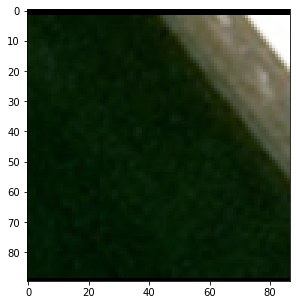

In [50]:
plot_im(tile_data[47050]['array'], (5,5))

In [ ]:
t = tile_data[23000]['geometry']['coordinates'][0]
t

In [ ]:
def get_triplet(triplets, start_ix):
    nbd, dist = None, None
    while dist is None:
        for k in np.random.choice(len(tile_data), 50, False):
            if tile_distance(tile_data[start_ix], tile_data[k]) >= 150:
                dist = k
                break
    while nbd is None:
        for k in np.random.choice(np.arange(max(0, start_ix-5000), min(len(tile_data), start_ix+5000)),
                                  50, False):
            if tile_distance(tile_data[start_ix], tile_data[k]) < 150:
                nbd = k
                break
    triplets.add((start_ix, nbd, dist))
    return triplets

In [ ]:
#triplets = set()
for ix in tqdm(range(len(tile_data))):
    triplets = get_triplet(triplets, ix)

In [ ]:
trip_list = list(triplets)

In [100]:
from scipy.stats import mode

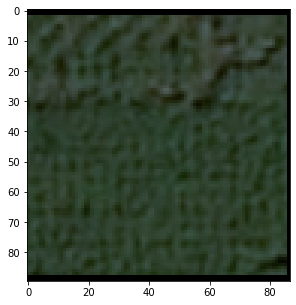

In [133]:
k = 0
plot_im(tile_data[k]['array'], (5,5))

In [134]:
tile_aoi = dl.scenes.AOI(tile_data[k]['geometry'], resolution=1)

```
fp = 'data/tiles_butte/tile_triplets.pickle'
with open(fp, 'wb') as path:
    pickle.dump(triplets, path, protocol=pickle.HIGHEST_PROTOCOL)
```

In [137]:
y = np.zeros(59999, dtype='int')
for k in tqdm(range(59999)):
    tile_aoi = dl.scenes.AOI(tile_data[k]['geometry'], resolution=1)
    scenes_area, ctx_area = dl.scenes.search(
                        tile_aoi,
                        products='usda:cdl:v1',
                        start_datetime="2019-07-28",
                        end_datetime="2020-01-01",
    #                   cloud_fraction=0.7,
                        limit=1
                       )
    y[k] = mode(np.array(scenes_area.stack('class', ctx_area))[0,0,:,:].flatten())[0][0]

In [136]:
mode(np.array(scenes_area.stack('class', ctx_area))[0,0,:,:].flatten())[0][0]

76

In [139]:
set(y)

{0,
 1,
 3,
 6,
 23,
 24,
 28,
 36,
 37,
 42,
 44,
 51,
 53,
 54,
 58,
 59,
 61,
 69,
 71,
 74,
 75,
 76,
 111,
 121,
 122,
 123,
 124,
 131,
 141,
 142,
 143,
 152,
 176,
 190,
 195,
 204,
 205,
 211,
 212,
 217,
 220,
 225}

In [24]:
ctx_area

AOI(geometry=<shapely.geom...x7f316c007f50>,
    resolution=30.0,
    crs='+proj=aea +l...s=m +no_defs ',
    align_pixels=True,
    bounds=(-121.93135535571191, 39.72501735408825, -121.92982061375231, 39.72620245137548),
    bounds_crs='EPSG:4326',
    shape=None)

In [31]:
tile_aoi

AOI(geometry=<shapely.geom...x7f316c01eb50>,
    resolution=1,
    crs=None,
    align_pixels=True,
    bounds=(-121.93135535571191, 39.72501735408825, -121.92982061375231, 39.72620245137548),
    bounds_crs='EPSG:4326',
    shape=None)